In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re
%matplotlib inline

# Import and Preprocess 

In [2]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('tagsets')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/rca2t/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rca2t/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/rca2t/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/rca2t/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/rca2t/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Revised import function

We pause to look at the revised form of our text import function. The parsing function has been replaced with NLTK, which has improved the results of POS tagging. However, this has required some added string manipulation to produce better tokens.

In [3]:
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

In [4]:
"""
NOTE: NLTK tokenization messes up whitespace and 
handles non-alpha characters differently.
"""

def text_to_tokens(
                   src_file,
                   body_start=0, 
                   body_end=-1, 
                   chap_pat=r'^\s*Chapter.*$', 
                   para_pat=r'\n\n+', 
                   sent_pat=r'([.;?!"“”]+)', 
                   token_pat=r'([\W_]+)'):

    # Text to lines
    lines = open(src_file, 'r', encoding='utf-8').readlines()
    lines = lines[body_start - 1 : body_end + 1]
    df = pd.DataFrame({'line_str':lines})
    df.index.name = 'line_id'
    del(lines)
    
    # FIX CHARACTERS TO IMPROVE TOKENIZATION
    df.line_str = df.line_str.str.replace('—', ' — ')
    df.line_str = df.line_str.str.replace('-', ' - ')

    # Lines to Chapters
    mask = df.line_str.str.match(chap_pat)
    df.loc[mask, 'chap_id'] = df.apply(lambda x: x.name, 1)
    df.chap_id = df.chap_id.ffill().astype('int')
    chap_ids = df.chap_id.unique().tolist()
    df['chap_num'] = df.chap_id.apply(lambda x: chap_ids.index(x))
    chaps = df.groupby('chap_num')\
        .apply(lambda x: ''.join(x.line_str))\
        .to_frame()\
        .rename(columns={0:'chap_str'})
    del(df)

    # Chapters to Paragraphs
    paras = chaps.chap_str.str.split(para_pat, expand=True)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'para_str'})
    paras.index.names = PARAS
    paras.para_str = paras.para_str.str.strip()
    paras.para_str = paras.para_str.str.replace(r'\n', ' ')
    paras.para_str = paras.para_str.str.replace(r'\s+', ' ')
    paras = paras[~paras.para_str.str.match(r'^\s*$')]
    del(chaps)

    # Paragraphs to Sentences
#     sents = paras.para_str.str.split(sent_pat, expand=True)\
    sents = paras.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    sents.index.names = SENTS
    del(paras)

    # Sentences to Tokens
#     tokens = sents.sent_str.str.split(token_pat, expand=True)\
    tokens = sents.sent_str\
        .apply(lambda x: pd.Series(nltk.pos_tag(nltk.word_tokenize(x))))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    tokens.index.names = OHCO
    del(sents)
    
    tokens['pos'] = tokens.pos_tuple.apply(lambda x: x[1])
    tokens['token_str'] = tokens.pos_tuple.apply(lambda x: x[0])
    tokens = tokens.drop('pos_tuple', 1)

    # Tag punctuation and numbers
    tokens['punc'] = tokens.token_str.str.match(r'^[\W_]*$').astype('int')
    tokens['num'] = tokens.token_str.str.match(r'^.*\d.*$').astype('int')
    
    # Extract vocab with minimal normalization
    WORDS = (tokens.punc == 0) & (tokens.num == 0)
    tokens.loc[WORDS, 'term_str'] = tokens.token_str.str.lower()\
        .str.replace(r'["_*.]', '')
    
    vocab = tokens[tokens.punc == 0].term_str.value_counts().to_frame()\
        .reset_index()\
        .rename(columns={'index':'term_str', 'term_str':'n'})
    vocab = vocab.sort_values('term_str').reset_index(drop=True)
    vocab.index.name = 'term_id'
    
    # Get priors for V
    vocab['p'] = vocab.n / vocab.n.sum()
    
    # Add stems
    stemmer = nltk.stem.porter.PorterStemmer()
    vocab['port_stem'] = vocab.term_str.apply(lambda x: stemmer.stem(x))
    
    # Define stopwords
    sw = pd.DataFrame({'x':1}, index=nltk.corpus.stopwords.words('english'))
    vocab['stop'] = vocab.term_str.map(sw.x).fillna(0).astype('int')
    del(sw)
            
    # Add term_ids to tokens 
    tokens['term_id'] = tokens['term_str'].map(vocab.reset_index()\
        .set_index('term_str').term_id).fillna(-1).astype('int')

    return tokens, vocab

def get_docs(tokens, div_names, doc_str = 'term_id', sep='', flatten=False, 
             index_only=False):
    
    if not index_only:
        docs = tokens.groupby(div_names)[doc_str]\
          .apply(lambda x: x.str.cat(sep=sep))
        docs.columns = ['doc_content']
    else:
        docs = tokens.groupby(div_names)[doc_str].apply(lambda x: x.tolist())

    if flatten:
        docs = docs.reset_index().drop(div_names, 1)
    
    return docs

def get_term_id(vocab, term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(vocab, term_id):
    return vocab.loc[term_id].term_str

In [5]:
src_file_name = '2701-0.txt'
src_file_url = 'https://www.gutenberg.org/files/2701/2701-0.txt'

import os

if not os.path.exists(src_file_name):
  import requests
  with open(src_file_name, 'w', encoding='utf-8') as src_file_on_disk:
    src_file_url = src_file_url
    src_file_text = requests.get(src_file_url).text
    src_file_on_disk.write(src_file_text)

cfg = dict(
    src_file = src_file_name,
    body_start = 341,
    body_end = 21964,
    chap_pat = r'^\s*(?:CHAPTER|ETYMOLOGY|Epilogue).*$'
)

K, V = text_to_tokens(**cfg)

In [6]:
# lemmatizer = nltk.stem.WordNetLemmatizer()
# # ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
# nouns = (K.punc == 0) & K.pos.str.match(r'^N')
# verbs = (K.punc == 0) & K.pos.str.match(r'^V')
# K.loc[nouns, 'lemma'] = K[nouns].apply(lambda x: lemmatizer.lemmatize(x.term_str, pos='n'), 1)
# K.loc[verbs, 'lemma'] = K[verbs].apply(lambda x: lemmatizer.lemmatize(x.term_str, pos='v'), 1)

In [7]:
K.head()

pos  token_str  punc  num   term_str  \
chap_num para_num sent_num token_num                                         
0        0        0        0          NNP  ETYMOLOGY     0    0  etymology   
                           1            .          .     1    0        NaN   
         1        0        0            (          (     1    0        NaN   
                           1          VBN   Supplied     0    0   supplied   
                           2           IN         by     0    0         by   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0             5005  
                           1               -1  
         1        0        0               -1  
                           1            14441  
                           2             1987

In [8]:
V.head()

,term_str,n,p,port_stem,stop
term_id,,,,,
0,a,4724,0.021629,a,1
1,aback,2,0.000009,aback,0
2,abaft,2,0.000009,abaft,0
3,abandon,3,0.000014,abandon,0
4,abandoned,7,0.000032,abandon,0


## Test to see if 'and' is annotated properly

In [9]:
K[K.term_str=='and'].pos

chap_num  para_num  sent_num  token_num
0         2         0         12           CC
                    1         7            CC
          3         0         10           CC
          4         1         4            CC
          5         2         0            CC
          8         0         9            CC
                              30           CC
                    3         43           CC
                              51           CC
          9         1         18           CC
                              40           CC
                              48           CC
                              54           CC
                              63           CC
                              67           CC
                    3         8            CC
                    4         5            CC
                              33           CC
                              44           CC
          11        0         1            CC
          15        0         11        

In [10]:
K[(K.term_str=='and') & K.pos.isna()]

,,,,pos,token_str,punc,num,term_str,term_id
chap_num,para_num,sent_num,token_num,,,,,,


## Discussion

* Why does NLTK's parser produce better results? 
* What does this imply about the POS algorithm? 

# Create DTM

*   Which bag? Chapters? Paragraphs?
*   Which item? tokens? terms? stems?
*   Let's try chapters and terms



## Create word mask

Let's filter out stopwords -- another hyperparameter. 

In [11]:
WORDS = (K.punc == 0) & (K.num == 0) & K.term_id.isin(V[V.stop==0].index)

## Extrct BOW from tokens

To extract a bag-of-words model from our tokens table, we apply a simple `groupby()` operation. Note that we can drop in our hyperparameters easily -- CHAPS and 'term_id' and be replaced. We can easily write a function to simplify this process and make it more configurable. 


In [12]:
BOW = K[WORDS].groupby(CHAPS+['term_id'])['term_id'].count()

In [13]:
BOW.head()

chap_num  term_id
0         33         1
          69         1
          70         1
          99         2
          129        1
Name: term_id, dtype: int64

## Convert BOW to DTM

In [14]:
DTM = BOW.unstack().fillna(0)

In [15]:
DTM.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,16935,16936,16937,16938,16939,16940,16941,16942,16943,16944
chap_num,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Discussion

* What is added in the process of converting our BOW data frame into a matrix?
* How would you characterize the difference between the BOW and the DTM data frames?



# Compute Term Frequencies and Weights

## Compute TF

In [16]:
alpha = .000001 # We introduce an arbitrary smoothing value
alpha_sum = alpha * V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [17]:
TF.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,16935,16936,16937,16938,16939,16940,16941,16942,16943,16944
chap_num,,,,,,,,,,,,,,,,,,,,,
0,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,...,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,5.017524e-04,5.017524e-04
1,9.336920e-10,9.336920e-10,9.336930e-04,9.336920e-10,9.336920e-10,9.336920e-10,9.336920e-10,9.336920e-10,9.336920e-10,9.336920e-10,...,9.336920e-10,9.336920e-10,9.336920e-10,9.336920e-10,9.336920e-10,9.336920e-10,9.336920e-10,9.336920e-10,9.336920e-10,9.336920e-10
2,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,...,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09
3,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,...,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10
4,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,...,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09


## Compute TFIDF

In [66]:
N_docs = DTM.shape[0]
V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / V[V.stop==0]['df'])

In [67]:
TFIDF.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,16935,16936,16937,16938,16939,16940,16941,16942,16943,16944
chap_num,,,,,,,,,,,,,,,,,,,,,
0,3.059699e-09,3.059699e-09,2.766193e-09,2.396419e-09,3.561451e-09,3.059699e-09,3.059699e-09,3.561451e-09,3.059699e-09,3.561451e-09,...,3.561451e-09,2.557947e-09,3.059699e-09,2.766193e-09,3.561451e-09,3.561451e-09,3.561451e-09,3.561451e-09,3.561455e-03,3.561455e-03
1,5.693684e-09,5.693684e-09,5.147514e-03,4.459410e-09,6.627376e-09,5.693684e-09,5.693684e-09,6.627376e-09,5.693684e-09,6.627376e-09,...,6.627376e-09,4.759992e-09,5.693684e-09,5.147509e-09,6.627376e-09,6.627376e-09,6.627376e-09,6.627376e-09,6.627376e-09,6.627376e-09
2,8.481069e-09,8.481069e-09,7.667510e-09,6.642547e-09,9.871856e-09,8.481069e-09,8.481069e-09,9.871856e-09,8.481069e-09,9.871856e-09,...,9.871856e-09,7.090281e-09,8.481069e-09,7.667510e-09,9.871856e-09,9.871856e-09,9.871856e-09,9.871856e-09,9.871856e-09,9.871856e-09
3,2.154769e-09,2.154769e-09,1.948069e-09,1.687659e-09,2.508124e-09,2.154769e-09,2.154769e-09,2.508124e-09,2.154769e-09,2.508124e-09,...,2.508124e-09,1.801414e-09,2.154769e-09,1.948069e-09,2.508124e-09,2.508124e-09,2.508124e-09,2.508124e-09,2.508124e-09,2.508124e-09
4,7.709104e-09,7.709104e-09,6.969597e-09,6.037929e-09,8.973300e-09,7.709104e-09,7.709104e-09,8.973300e-09,7.709104e-09,8.973300e-09,...,8.973300e-09,6.444909e-09,7.709104e-09,6.969597e-09,8.973300e-09,8.973300e-09,8.973300e-09,8.973300e-09,8.973300e-09,8.973300e-09


## Compute TFTH (Experiment)

In [20]:
THM = -(TF * np.log2(TF))
TFTH = TF.apply(lambda x: x * THM.sum(), 1)

In [21]:
TFTH.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,16935,16936,16937,16938,16939,16940,16941,16942,16943,16944
chap_num,,,,,,,,,,,,,,,,,,,,,
0,1.211241e-11,5.621709e-12,2.023569e-11,3.792221e-11,6.519129e-12,8.523135e-12,1.646764e-11,7.500809e-12,1.361376e-11,2.292857e-12,...,9.154935e-12,3.659806e-11,6.467647e-12,3.043225e-11,3.892685e-12,4.510988e-12,5.806689e-12,6.429971e-12,2.763670e-06,2.763670e-06
1,2.253955e-11,1.046124e-11,3.765591e-05,7.056807e-11,1.213121e-11,1.586040e-11,3.064405e-11,1.395799e-11,2.533336e-11,4.266695e-12,...,1.703609e-11,6.810401e-11,1.203541e-11,5.663027e-11,7.243758e-12,8.394336e-12,1.080546e-11,1.196530e-11,5.142810e-12,5.142810e-12
2,3.357395e-11,1.558261e-11,5.609058e-11,1.051152e-10,1.807014e-11,2.362497e-11,4.564606e-11,2.079122e-11,3.773549e-11,6.355486e-12,...,2.537623e-11,1.014448e-10,1.792744e-11,8.435403e-11,1.078999e-11,1.250384e-11,1.609535e-11,1.782300e-11,7.660510e-12,7.660510e-12
3,8.530067e-12,3.959044e-12,1.425083e-11,2.670641e-11,4.591045e-12,6.002350e-12,1.159721e-11,5.282385e-12,9.587382e-12,1.614726e-12,...,6.447290e-12,2.577389e-11,4.554789e-12,2.143167e-11,2.741392e-12,3.176828e-12,4.089315e-12,4.528256e-12,1.946291e-12,1.946291e-12
4,3.051798e-11,1.416425e-11,5.098510e-11,9.554739e-11,1.642536e-11,2.147458e-11,4.149126e-11,1.889876e-11,3.430072e-11,5.776997e-12,...,2.306643e-11,9.221110e-11,1.629564e-11,7.667596e-11,9.807865e-12,1.136572e-11,1.463032e-11,1.620072e-11,6.963234e-12,6.963234e-12


## Add stats to V

In [22]:
V['tf_sum'] = TF.sum()
V['tf_mean'] = TF.mean()
V['tf_max'] = TF.max()
V['tfidf_sum'] = TFIDF.sum()
V['tfidf_mean'] = TFIDF.mean()
V['tfidf_max'] = TFIDF.max()
V['tfth_sum'] = TFTH.sum()
V['tfth_mean'] = TFTH.mean()
V['tfth_max'] = TFTH.max()
V['th_sum'] = THM.sum()
V['th_mean'] = THM.mean()
V['th_max'] = THM.max()

## Discussion

* Why do we add summary statistics to the vocabulary table?

# Find Significant Words

In [23]:
TOPS = pd.DataFrame(index=range(10))
for m in ['tf','tfidf','tfth', 'th']:
    for n in ['mean','max']:
        key = '{}_{}'.format(m,n)
        TOPS[key] = V.sort_values(key, ascending=False).term_str.head(10).tolist()

In [24]:
TOPS

,tf_mean,tf_max,tfidf_mean,tfidf_max,tfth_mean,tfth_max,th_mean,th_max
0,whale,um,um,um,whale,whale,whale,um
1,one,thunder,ahab,thunder,one,one,one,thunder
2,like,oil,ye,rum,like,ye,like,oil
3,upon,rum,queequeg,want,upon,um,upon,rum
4,man,want,thou,lashings,man,ahab,man,want
5,ahab,ye,stubb,bucket,ahab,man,would,ye
6,ye,fish,sir,bulkington,would,like,ship,fish
7,ship,pipe,whale,jonah,ship,sea,ahab,pipe
8,would,sir,thunder,pipe,sea,upon,sea,sir
9,sea,ha,starbuck,cough,old,thunder,old,ha


# Compare Chapters

## Create Docs table

In [25]:
D = get_docs(K, CHAPS, 'term_str', sep=" ")\
    .to_frame().rename(columns={'term_str':'doc_str'})

In [26]:
D.head()

,doc_str
chap_num,
0,etymology supplied by a late consumptive usher...
1,chapter loomings call me ishmael some years ag...
2,chapter the carpet bag i stuffed a shirt or tw...
3,chapter the spouter inn entering that gable en...
4,chapter the counterpane upon waking next morni...


In [27]:
D['term_count'] = DTM.sum(1).astype('int').to_frame().rename(columns={0:'term_count'})
D['tf'] = D.term_count / D.term_count.sum()

In [28]:
D.head()

,doc_str,term_count,tf
chap_num,,,
0,etymology supplied by a late consumptive usher...,1993,0.018051
1,chapter loomings call me ishmael some years ag...,1071,0.009700
2,chapter the carpet bag i stuffed a shirt or tw...,719,0.006512
3,chapter the spouter inn entering that gable en...,2830,0.025632
4,chapter the counterpane upon waking next morni...,791,0.007164


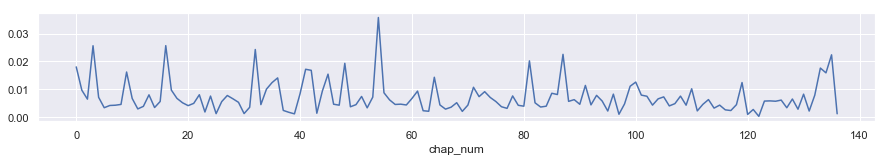

In [29]:
D.tf.plot(figsize=(15,2))

## Get all doc pairs

In [30]:
chap_ids = D.index.tolist()
pairs = [(i,j) for i in chap_ids for j in chap_ids if j > i]

In [31]:
P = pd.DataFrame(pairs).reset_index(drop=True).set_index([0,1])
P.index.names = ['doc_x','doc_y']

In [32]:
P.head()

Empty DataFrame
Columns: []
Index: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]

## Compute Euclidean distance

In [33]:
def euclidean(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = (D1 - D2)**2
    y = x.sum() 
    z = np.sqrt(y)
    return z

In [34]:
P['euclidean'] = 0
P['euclidean'] = P.apply(euclidean, 1)

In [35]:
P['euclidean_sim'] = 1 / (P.euclidean + 1)

In [36]:
PME = P.euclidean.unstack().fillna(0)

In [37]:
PME.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,127,128,129,130,131,132,133,134,135,136
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.174179,0.205737,0.156459,0.197897,0.242148,0.255097,0.230901,0.251028,0.208663,0.190091,...,0.254874,0.181217,0.273255,0.170700,0.248984,0.181002,0.145870,0.145798,0.141013,0.347628
1,0.000000,0.217560,0.172748,0.209998,0.251201,0.263195,0.243515,0.260404,0.223955,0.201891,...,0.268044,0.196612,0.285162,0.185443,0.261658,0.196576,0.166898,0.164915,0.161102,0.354813
2,0.000000,0.000000,0.197813,0.231557,0.274446,0.274800,0.263181,0.279130,0.247545,0.227961,...,0.285633,0.225730,0.301587,0.216332,0.281493,0.224347,0.198565,0.197765,0.192821,0.370314
3,0.000000,0.000000,0.000000,0.180867,0.228593,0.253178,0.230168,0.246647,0.205757,0.179513,...,0.254312,0.179021,0.271403,0.168020,0.248755,0.178861,0.146103,0.145540,0.139880,0.345891
4,0.000000,0.000000,0.000000,0.000000,0.261861,0.279144,0.259408,0.274901,0.240074,0.213057,...,0.282908,0.216698,0.298266,0.203713,0.276329,0.214482,0.188408,0.188016,0.183048,0.366265


## Compute Cosine similarity

In [38]:
def cosine(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = D1 * D2
    y = x.sum()
    
#     a = np.sqrt(D1.sum()**2)     # <-- misplaced exponent!
#     b = np.sqrt(D2.sum()**2)     # <-- misplaced exponent!
#     c = np.sqrt(a) * np.sqrt(b)  # <-- extra square roots!

    a = np.sqrt((D1**2).sum())
    b = np.sqrt((D2**2).sum())
    c = a * b
    
    z = y / c
    return z

In [39]:
from numpy.linalg import norm
def cosine_np(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    return np.dot(D1, D2)/(norm(D1)*norm(D2))

In [40]:
from scipy import spatial
def cosine_scipy(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    return (1 - spatial.distance.cosine(D1, D2))

In [41]:
from sklearn.metrics.pairwise import cosine_similarity
def cosine_sklearn(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    return cosine_similarity([TFIDF.loc[0]], [TFIDF.loc[1]])[0][0]

In [42]:
# %%timeit -- 11.8 s ± 958 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
P['cosine'] = P.apply(cosine, 1)

In [43]:
# %%timeit -- 7.23 s ± 877 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
P['cosine_scipy'] = P.apply(cosine_scipy, 1)

In [44]:
# %%timeit -- 39.6 s ± 3.27 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
P['cosine_sklearn'] = P.apply(cosine_sklearn, 1)

In [45]:
# %%timeit -- 4.48 s ± 480 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
P['cosine_np'] = P.apply(cosine_np, 1)

In [46]:
P.head()

euclidean  euclidean_sim    cosine  cosine_scipy  cosine_sklearn  \
doc_x doc_y                                                                     
0     1       0.174179       0.851659  0.073214      0.073214        0.073214   
      2       0.205737       0.829368  0.053051      0.053051        0.073214   
      3       0.156459       0.864709  0.072381      0.072381        0.073214   
      4       0.197897       0.834796  0.035144      0.035144        0.073214   
      5       0.242148       0.805057  0.029475      0.029475        0.073214   

             cosine_np  
doc_x doc_y             
0     1       0.073214  
      2       0.053051  
      3       0.072381  
      4       0.035144  
      5       0.029475

In [47]:
PMC = P.cosine.unstack().fillna(0)

In [48]:
PMC.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,127,128,129,130,131,132,133,134,135,136
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.073214,0.053051,0.072381,0.035144,0.029475,0.051719,0.054132,0.030658,0.073249,0.049146,...,0.059140,0.067775,0.041260,0.060595,0.045744,0.073573,0.106078,0.101738,0.105405,0.019233
1,0.000000,0.060451,0.074112,0.048132,0.046757,0.067870,0.041883,0.041507,0.044929,0.067955,...,0.032564,0.056053,0.022245,0.065373,0.027383,0.059343,0.060829,0.079757,0.077401,0.024209
2,0.000000,0.000000,0.121064,0.077275,0.031343,0.121053,0.058287,0.053983,0.045955,0.064313,...,0.050673,0.034583,0.041863,0.038441,0.034490,0.048881,0.054283,0.059643,0.078444,0.023894
3,0.000000,0.000000,0.000000,0.194504,0.149458,0.061433,0.051456,0.063650,0.091356,0.145556,...,0.056034,0.077392,0.050707,0.074863,0.038866,0.082662,0.082996,0.084646,0.098274,0.028823
4,0.000000,0.000000,0.000000,0.000000,0.072376,0.046303,0.032629,0.035674,0.043404,0.119051,...,0.022539,0.037129,0.020745,0.071201,0.021977,0.059303,0.056304,0.056938,0.073655,0.016296


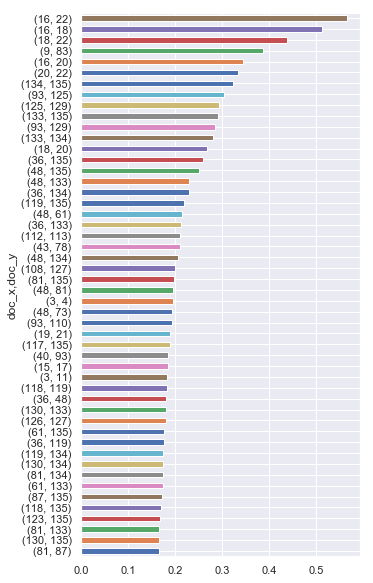

In [49]:
P.cosine.sort_values(ascending=True).tail(50).plot(kind='barh', figsize=(5,10))

In [50]:
P.cosine.reset_index().to_csv('moby-chapter-pairs.csv', index=False)

## Compare Euclidean and Cosine metrics

In [51]:
def len_diff(row):
    return abs(D.loc[row.name[0]].term_count - D.loc[row.name[1]].term_count)

In [52]:
P['len_diff'] = P.apply(len_diff, axis=1)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


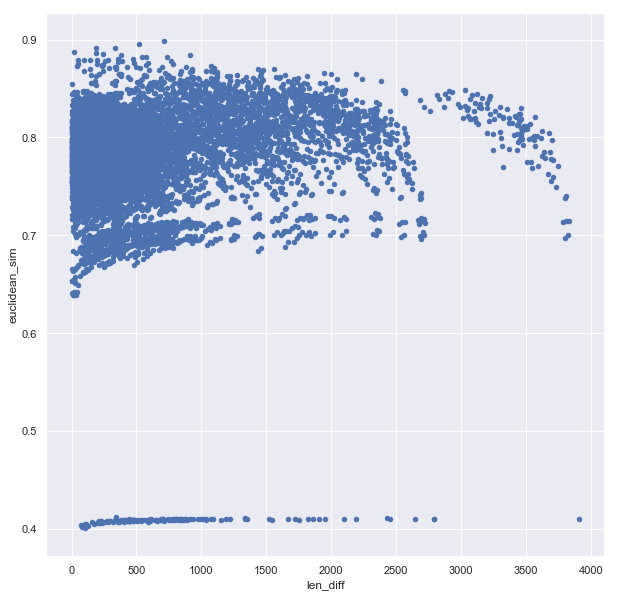

In [53]:
P.plot(kind='scatter', x='len_diff', y='euclidean_sim', figsize=(10,10))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


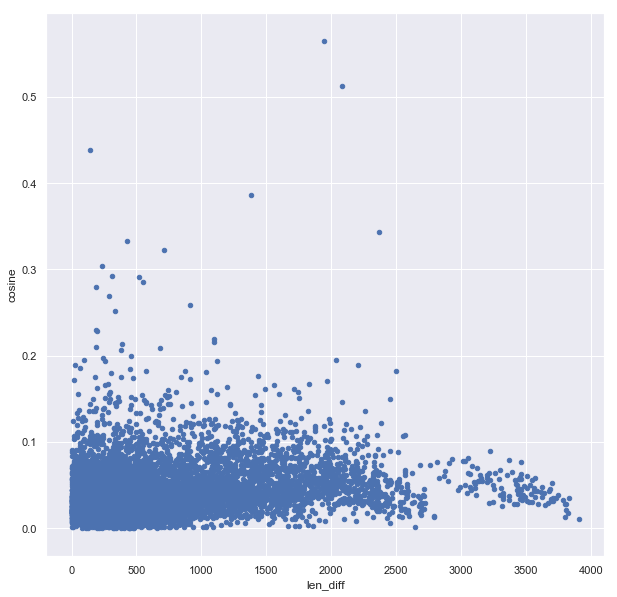

In [54]:
P.plot(kind='scatter', x='len_diff', y='cosine', figsize=(10,10))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


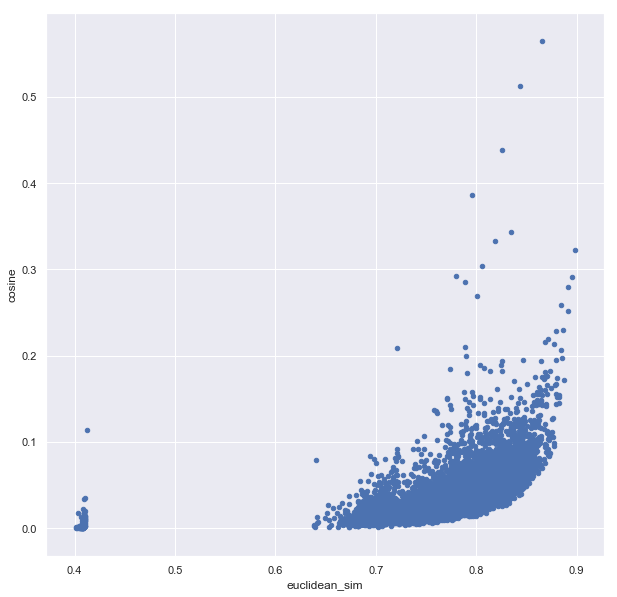

In [55]:
P.plot(kind='scatter', x='euclidean_sim', y='cosine', figsize=(10,10))

In [56]:
P[P.euclidean > .8]

,,euclidean,euclidean_sim,cosine,cosine_scipy,cosine_sklearn,cosine_np,len_diff
doc_x,doc_y,,,,,,,
0,122,1.438838,0.410031,0.007715,0.007715,0.073214,0.007715,1955
1,122,1.441334,0.409612,0.002942,0.002942,0.073214,0.002942,1033
2,122,1.444511,0.409080,0.007526,0.007526,0.073214,0.007526,681
3,122,1.438089,0.410157,0.012898,0.012898,0.073214,0.012898,2792
4,122,1.444279,0.409119,0.001023,0.001023,0.073214,0.001023,753
5,122,1.451116,0.407977,0.000478,0.000478,0.073214,0.000478,342
6,122,1.452988,0.407666,0.003912,0.003912,0.073214,0.003912,430
7,122,1.449686,0.408216,0.000398,0.000398,0.073214,0.000398,441
8,122,1.452520,0.407744,0.001125,0.001125,0.073214,0.001125,472


## See most similar chapters

In [57]:
P.cosine.sort_values(ascending=False)

doc_x  doc_y
16     22       5.646717e-01
       18       5.120610e-01
18     22       4.380624e-01
9      83       3.856228e-01
16     20       3.430556e-01
20     22       3.328176e-01
134    135      3.218411e-01
93     125      3.038601e-01
125    129      2.924324e-01
133    135      2.905981e-01
93     129      2.851038e-01
133    134      2.793958e-01
18     20       2.686306e-01
36     135      2.589574e-01
48     135      2.513222e-01
       133      2.294618e-01
36     134      2.289439e-01
119    135      2.195282e-01
48     61       2.155078e-01
36     133      2.130139e-01
112    113      2.095514e-01
43     78       2.091925e-01
48     134      2.065827e-01
108    127      1.993047e-01
81     135      1.967656e-01
48     81       1.949853e-01
3      4        1.945038e-01
48     73       1.940197e-01
93     110      1.932942e-01
19     21       1.887712e-01
                    ...     
56     122      1.003502e-03
25     39       9.999504e-04
24     122      9.108570e-04
9

In [58]:
D.loc[16]

doc_str       chapter the ship in bed we concocted our plans...
term_count                                                 2834
tf                                                    0.0256687
Name: 16, dtype: object

In [59]:
D.loc[22]

doc_str       chapter merry christmas at length towards noon...
term_count                                                  892
tf                                                    0.0080792
Name: 22, dtype: object

# Compare Significant Words 

We look at distributions of words over chapters. Note, we are not comparing word vectors per se -- we are looking at sequences of words, which has not been discussed in the literature. 

In [60]:
import matplotlib.pyplot as plt

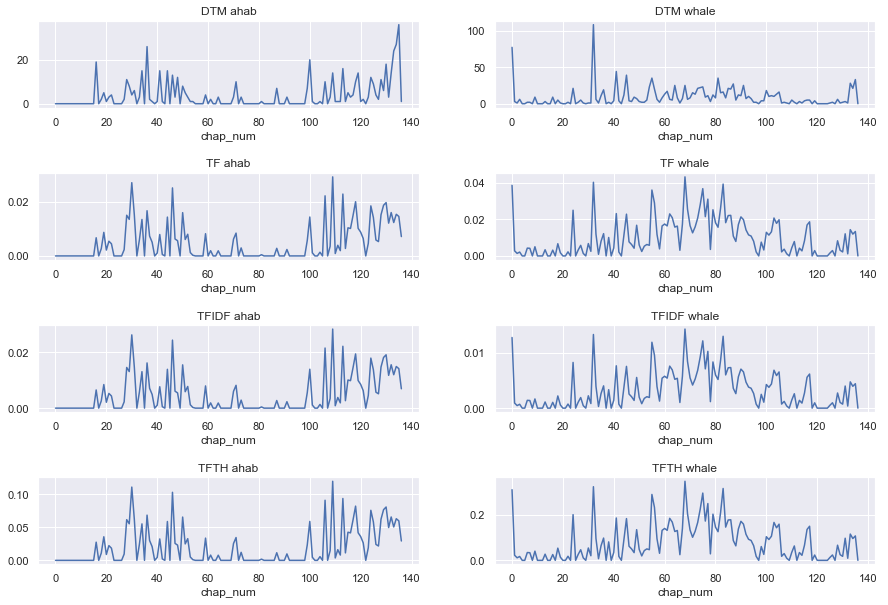

In [61]:
FIG = dict(figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2)
for i, w in enumerate('ahab whale'.split()):
    W = get_term_id(V, w)
    DTM[W].plot(**FIG, ax=axes[0, i], title="DTM {}".format(w))
    TF[W].plot(**FIG, ax=axes[1, i], title="TF {}".format(w))
    TFIDF[W].plot(**FIG, ax=axes[2, i], title="TFIDF {}".format(w))
    TFTH[W].plot(**FIG, ax=axes[3, i], title="TFTH {}".format(w))
fig.subplots_adjust(hspace=.75)